<a href="https://colab.research.google.com/github/doug14226/colab1/blob/master/Beyond_The_Mono_Maze.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Adding Save/Load Maze to the maze generator
Copyright (c) 2016 Sami Salkosuo  
Copyright (c) 2018 Douglas Lange.  
Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

HE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.



##Ssection 1 :  Install required libraries, packages and files 

---
Install Cairo library and python code from previous example..
Execution of this block will produce a setup.log file.
If faults occur, please download setup.log and post new issue with setup.log as attachment at https://github.com/doug14226/colab1/issues. To download setup.log run the following in a new  cell.  (to add cell press +code above)

---
from google.colab import files  
files.download("setup.log")



In [20]:
def dougpawsFirstMazeSetup():
  
  def install_not_needed():
    lsout = !ls -l firstmaze.py
    if len(lsout[0].split()) > 4 and (lsout[0].split()[4] == '13368'):
      try:
        import cairo
        return(True)
      except ImportError:
        return(False)
    else:
      return(False)

  if install_not_needed():
    print("All requirements met, install not needed")
    return

  log = open("setup.log","a")

  def printlog(cmdout,log): 
    for line in cmdout:
      print(line, file = log)
      
  print("\nSetup required ", file = log)
  from datetime import datetime
  print(datetime.utcnow(), file = log)
  import sys
  print("Log Python Version", file = log)
  print(sys.version, file=log)
  cmdout = !uname -a
  print("ID OS version", file = log)
  printlog(cmdout, log)
  cmdout = ! ls -l firstmaze.py
  if (cmdout[0].split()[4] != '15364'):
    cmdout =!wget -O firstmaze.py "https://drive.google.com/uc?export=download&id=1E6V_ligNwiDT6u07K8D8-6iR3BPjxvb7"
    print("installing firstmaze.py",file = log )
    printlog(cmdout, log)

  print("installing cairo", file = log )
  cmdout = !apt-get install libcairo2-dev
  printlog(cmdout, log)
  cmdout = !pip3 install pycairo
  printlog(cmdout, log)

  if install_not_needed():
    print("Install finished without errors")
  else:
    print("Install failed, check setup.log")

dougpawsFirstMazeSetup()    

All requirements met, install not needed


##Section 2: Import classes and functions to be reused form firstMaze.ipynb

In [0]:
from firstmaze import Cell, Distances, initWilsonMaze, displayMaze

##Section 3: Class *Cell*, define data and methods of *Cell* objects.

In [0]:
class Cell:
    def __init__(self, row, column):
        self.row = row
        self.column = column
        self.directions = ('north', 'west', 'south', 'east')  # ccw order required
        self.nearby = dict()      # key is direction (i.e. 'east') value is cell object
        self.links = dict()       # key is nearby cell object value is true
        self.attributes = dict()

    def link(self, cell, bidi=True):
        self.links[cell] = True
        if bidi is True:
            cell.link(self, False)
        return self

    def getLinks(self):
        return self.links.keys()

    def neighbors(self):
        myNeighbors = [self.nearby[d] for d in self.directions]
        return [x for x in filter(None, myNeighbors)]

    def directionToText(self, direction):
        if isinstance(direction,str):
          return direction
        else:
          return self.directions[direction]

    def fillCell(self, ctx, pointsPerCell, hue):
        yU = self.row*pointsPerCell+4
        xL = self.column*pointsPerCell+4
        ctx.rectangle(xL, yU, pointsPerCell, pointsPerCell)
        ctx.set_source_rgb(*hue)
        ctx.fill()

    def drawCell(self, ctx, pointsPerCell, rows, columns):
        yU = self.row*pointsPerCell+4
        yL = yU+pointsPerCell
        xL = self.column*pointsPerCell+4
        xR = xL+pointsPerCell
        ctx.set_source_rgb(0, 0, 0)
        ctx.set_line_width(4)
        if not(self.hasNeighbor("east")) and self.column < (columns-1):
            ctx.move_to(xR, yU-2)
            ctx.line_to(xR, yL+2)
            ctx.stroke()
        if not(self.hasNeighbor("south")) and self.row < (rows-1):
            ctx.move_to(xL, yL)
            ctx.line_to(xR, yL)
            ctx.stroke()

    def hasNeighbor(self, direction):
        direction = self.directionToText(direction)
        myNeighbor = self.nearby[direction]
        return myNeighbor in self.links

    def getDistances(self, pallet=0):
        distances = Distances(self, rootPallet=pallet)
        frontier = []
        frontier.append(self)
        while len(frontier) > 0:
            newFrontier = []
            for cell in frontier:
                for linked in cell.getLinks():
                    if distances.getDistanceTo(linked) is None:
                        dist = distances.getDistanceTo(cell)
                        distances.setDistanceTo(linked, dist+1)
                        distances.setPallet(linked, pallet)
                        newFrontier.append(linked)
            frontier = newFrontier
        return distances

    def dumpCell(self, fileID):
        myNearby = None
        myLinks =dict()
        for d in self.directions:
            k = self.nearby.get(d)
            if k is not None:
                myNearby = [k.row, k.column]
                l = self.links.get(k)
                if l:
                    myLinks[d] = myNearby
        thisObj = [[self.row, self.column], myLinks, self.attributes]
        jsonObj = json.dumps(thisObj)
        print(jsonObj, file=fileID)



##Section 4: Class Grid for rectangular mazes

In [0]:

class Grid:
    def __init__(self, rows, columns, cellClass=Cell):
        self.CellClass = cellClass
        self.rows = rows
        self.columns = columns
        self.grid = self.prepareGrid()
        self.distances = None
        self.configureCells()
        self.pointsPerCell = 18
        self.start = None              # cell of path start
        self.goal = None               # cell of path goal
        self.ctx = None
        self.coloring = None

    def prepareGrid(self):
        rowList = []
        i = 0
        j = 0
        for i in range(self.rows):
            columnList = []
            for j in range(self.columns):
                columnList.append(self.CellClass(i, j))
            rowList.append(columnList)
        return rowList

    def configureCells(self):
        for cell in self.eachCell():
            row = cell.row
            col = cell.column
            cell.nearby['north'] = self.getCell(row-1, col)
            cell.nearby['east'] = self.getCell(row, col+1)
            cell.nearby['south'] = self.getCell(row+1, col)
            cell.nearby['west'] = self.getCell(row, col-1)

    def eachRow(self):
        for row in self.grid:
            yield row

    def eachCell(self):
        for row in self.grid:
            for cell in row:
                yield cell

    def drawGrid(self, filename=None, pointsPerCell=18):
        WIDTH, HEIGHT = self.columns*pointsPerCell+8, self.rows*pointsPerCell+8
        surface = cairo.SVGSurface(filename, WIDTH, HEIGHT)
        self.ctx = cairo.Context(surface)
        self.ctx.set_line_join(cairo.LINE_JOIN_MITER)
        self.ctx.stroke()
        self.ctx.set_line_join(cairo.LINE_JOIN_MITER)
        self.ctx.stroke()
        if self.coloring is not None:
            for row in self.grid:
                for cell in row:
                    d = self.distances.cells.get(cell, 0)
                    hue = self.coloring.cellRGB(d, cell)
                    cell.fillCell(self.ctx, self.pointsPerCell, hue)
        for row in self.grid:
            for cell in row:
                cell.drawCell(self.ctx, self.pointsPerCell, self.rows, self.columns)
        self.ctx.set_source_rgb(0, 0, 0)
        self.ctx.set_line_width(4)
        self.ctx.set_line_join(cairo.LINE_JOIN_MITER)
        self.ctx.rectangle(4, 4, self.columns*self.pointsPerCell, self.rows*self.pointsPerCell)
        self.ctx.stroke()
        if self.coloring is not None:        
            d = self.distances.cells.get(seld.start, 0)
            hue = self.coloring.cellRGB(d, self.start)
            self.drawOpening(self.start, hue)
            d = self.distances.cells.get(seld.goal, 0)
            hue = self.coloring.cellRGB(d, self.goal)
            self.drawOpening(self.goal, hue)
        return surface


    def drawOpening(self, cell, hue):
        self.ctx.set_source_rgb(*hue)
        self.ctx.set_line_cap(cairo.LINE_CAP_BUTT)
        if cell.row == 0:
            self.ctx.move_to(4+2+(cell.column*self.pointsPerCell), 4)
            self.ctx.line_to(4-2+((cell.column+1)*self.pointsPerCell), 4)
            self.ctx.stroke()
        elif cell.row == self.rows - 1:
            self.ctx.move_to(4+2+(cell.column*self.pointsPerCell), self.rows*self.pointsPerCell + 4)
            self.ctx.line_to(4-2+((cell.column+1)*self.pointsPerCell), self.rows*self.pointsPerCell + 4)
            self.ctx.stroke()        
        elif cell.column == 0:
            self.ctx.move_to(4, 4+2+(cell.row*self.pointsPerCell))
            self.ctx.line_to(4, 4-2+((cell.row+1)*self.pointsPerCell))
            self.ctx.stroke()
        elif cell.column == self.columns - 1:
            self.ctx.move_to(self.columns*self.pointsPerCell+4,
                             (cell.row*self.pointsPerCell+4+2))
            self.ctx.line_to(self.columns*self.pointsPerCell+4,
                             (4-2+(cell.row+1)*self.pointsPerCell))
            self.ctx.stroke()

    def getDistancesFromPath(self, start, goal, pallet=0):
        distancesToStart = start.getDistances(pallet)
        distancesToGoal = goal.getDistances(pallet)
        pathLength = distancesToGoal.getDistanceTo(start)
        sumDistances = distancesToStart + distancesToGoal
        return (sumDistances - pathLength)
    
    def getCell(self, row, column):
        if not 0 <= row < self.rows:
            return None
        if not 0 <= column < self.columns:
            return None
        return self.grid[row][column]

    def dumpGrid(self, jsonFileName):
        f = open(jsonFileName, "w", encoding="utf-8")
        thisObj = [str(type(self)), [self.rows, self.columns]]
        jsonObj = json.dumps(thisObj)
        jsonObj
        print(jsonObj, file=f)
        for row in self.grid:
            for cell in row:
                cell.dumpCell(f)
        f.close()


##Section 5: initMazeFromJson(jsonFileName) 
create and initialize from saved json file

In [0]:
def initMazeFromJson(jsonFileName):
    f = open(jsonFileName, "r", encoding="utf-8")
    jsonObj = f.readline()
    thisNode = json.loads(jsonObj)
    className = re.search(r"(\.)(\w+)(\')", thisNode[0]).group(2)
    params = thisNode[1]
    g = globals()
    c = g[className]
    grid = c(*params)
    row = operator.itemgetter(0)
    col = operator.itemgetter(1)
    jsonObj = f.readline()
    while jsonObj:
        thisRecord = json.loads(jsonObj)
        thisObj = thisRecord[0]
        cell = grid.grid[row(thisObj)][col(thisObj)]
        thisLinks = thisRecord[1]
        keys = list(thisLinks.keys())
        for i in keys:
            thisNeighbor = thisLinks[i]
            cellNeighbor = grid.grid[row(thisNeighbor)][col(thisNeighbor)]
            cell.link(cellNeighbor, bidi=False)
        if len(thisRecord) > 3:
            cell.attributes = dict(thisRecord[2])
        jsonObj = f.readline()
    f.close()
    return grid


##Main Program:  

In [0]:
import random, cairo, json

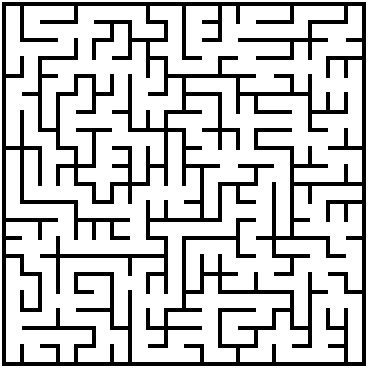

In [27]:
#@title Maze Parameters
FileName = "Example" #@param {type:"string"}
#@markdown Maze Size
Rows = 20 #@param {type:"integer"}
Columns = 20 #@param {type:"integer"}

def main():
  grid  = Grid(Rows, Columns)
  grid  = initWilsonMaze(grid)
  SaveName = FileName + ".json"
  grid.dumpGrid(SaveName)
  startRow = 0  
  startColumn = random.randint(0, Columns-1)
  grid.start = grid.getCell(startRow, startColumn)
  goalRow = Rows-1 
  goalColumn = random.randint(0, Columns-1)
  grid.goal = grid.getCell(goalRow, goalColumn)
  grid.distances = grid.getDistancesFromPath(grid.start, grid.goal)
  GridName = FileName + ".SVG"
  surface = grid.drawGrid(GridName)
  displayMaze(surface)

main()

In [0]:
#@title Output { run: "auto" }
downloadPDF = False #@param {type:"boolean"}
from google.colab import files
if downloadPDF: files.download(FileName)


In [0]:
#@title Download setup.log?
download_setup_log = False #@param {type:"boolean"}
from google.colab import files
if download_setup_log:
  files.download('setup.log')

In [28]:
!ls -l

total 116
-rw-r--r-- 1 root root 20397 Jun 14 20:14 Example.json
-rw-r--r-- 1 root root 60663 Jun 14 20:14 Example.SVG
-rw-r--r-- 1 root root 13368 Jun 14 20:03 firstmaze.py
drwxr-xr-x 2 root root  4096 Jun 14 20:04 __pycache__
drwxr-xr-x 1 root root  4096 May 31 16:17 sample_data
-rw-r--r-- 1 root root  9093 Jun 14 20:04 setup.log
